In [3]:
import multiprocessing
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
) #TODO: [@task] Add this to the readme. This should be outside the package
import jax
print(jax.local_device_count())

import jax.numpy as jnp
import optax

from bde.bde import BDE

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

data = fetch_openml(name="airfoil_self_noise", as_frame=True)

X = data.data.values   # shape (1503, 5)
y = data.target.values.reshape(-1, 1)  # shape (1503, 1)

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

# Convert to JAX arrays
X_train = jnp.array(X_train, dtype=jnp.float32)
y_train = jnp.array(y_train, dtype=jnp.float32)
X_test = jnp.array(X_test, dtype=jnp.float32)
y_test = jnp.array(y_test, dtype=jnp.float32)

Xmu, Xstd = jnp.mean(X_train, 0), jnp.std(X_train, 0) + 1e-8
Ymu, Ystd = jnp.mean(y_train, 0), jnp.std(y_train, 0) + 1e-8

Xtr = (X_train - Xmu) / Xstd
Xte = (X_test  - Xmu) / Xstd
ytr = (y_train - Ymu) / Ystd
yte = (y_test  - Ymu) / Ystd

sizes = [5, 16, 16, 2]

8


/Users/yellouz/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/datasets/_openml.py:320: UserWarning: Multiple active versions of the dataset matching the name airfoil_self_noise exist. Versions may be fundamentally different, returning version 1. Available versions:
- version 1, status: active
  url: https://www.openml.org/search?type=data&id=43919
- version 8, status: active
  url: https://www.openml.org/search?type=data&id=44957

  warn(warning_msg)


In [6]:
bde = BDE(
        n_members=5,
        sizes=sizes,
        seed=0,
        loss="gaussian",
        )

bde.train(
        X=Xtr,
        y=ytr,
        epochs=1000,
        lr=1e-3,
        warmup_steps=500,
        n_samples=1000,
        n_thinning=10,
        )

means, sigmas = bde.evaluate(Xte)

AttributeError: 'function' object has no attribute 'validate_loss'

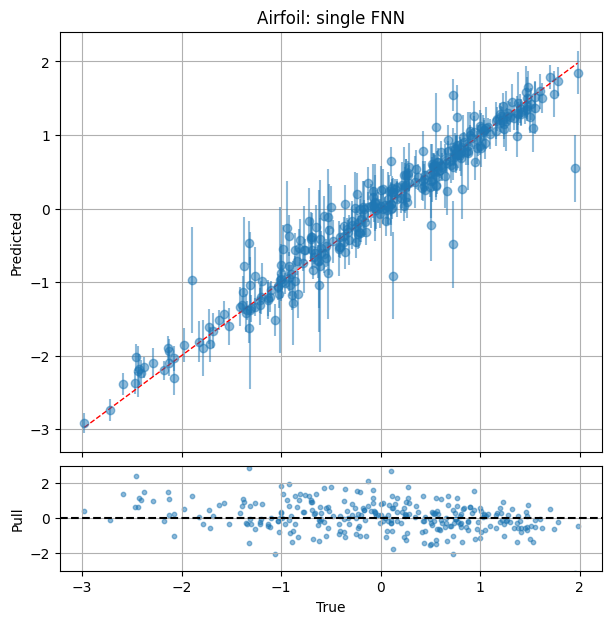

In [ ]:
y_pred_sampled = means
y_err_sampled  = sigmas
y_true = yte 

yt = np.asarray(y_true).ravel()
yp_sampled = np.asarray(y_pred_sampled).ravel()
ye_sampled = np.asarray(y_err_sampled).ravel()
ye_sampled = np.maximum(ye_sampled, 1e-8)  # guard

fig = plt.figure(figsize=(7,7))
gs  = gridspec.GridSpec(2,1, height_ratios=[4,1], hspace=0.05)

ax = plt.subplot(gs[0])
ax.errorbar(yt, yp_sampled, yerr=ye_sampled, fmt='o', alpha=0.5)
m, M = float(min(yt.min(), yp_sampled.min())), float(max(yt.max(), yp_sampled.max()))
ax.plot([m,M],[m,M], 'r--', lw=1)
ax.set_ylabel("Predicted"); ax.set_title("Airfoil: single FNN"); ax.grid(True)
plt.setp(ax.get_xticklabels(), visible=False)


ax2 = plt.subplot(gs[1], sharex=ax)
pull_sampled = (yp_sampled - yt) / ye_sampled
ax2.axhline(0, color='k', ls='--')
ax2.scatter(yt, pull_sampled, s=10, alpha=0.5)
ax2.set_xlabel("True"); ax2.set_ylabel("Pull"); ax2.set_ylim(-3,3); ax2.grid(True)

In [ ]:
import jax.numpy as jnp
from scipy.stats import norm

y = jnp.asarray(yt)
mean = jnp.asarray(means)
sigma = jnp.asarray(sigmas)

print("RSME: ", jnp.sqrt(jnp.mean((means - yt) ** 2)))

var = jnp.clip(sigmas**2, 1e-12, None)
lppd_i = -0.5 * (jnp.log(2 * jnp.pi * var) + (yt - means) ** 2 / var) 
total = jnp.sum(lppd_i)
print("Total log predictive density: ", total)


RSME:  0.24458896
Total log predictive density:  69.90759
